# DJSSP without training without JOB Interrupt

In [1]:
import torch
if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 4
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 4
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

In [2]:
import time

from rl4co.envs.scheduling.djssp.env import DJSSPEnv
from rl4co.models import L2DPolicy, L2DModel
from rl4co.utils import RL4COTrainer
import gc
from rl4co.envs import JSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os
%load_ext autoreload
%autoreload 2
generator_params = {
"num_jobs" : 8 ,
"num_machines": 8 ,
"min_processing_time": 1 ,
"max_processing_time": 99 ,
"mtbf" : 17 ,
"mttr" : 4
}
env = DJSSPEnv(generator_params=generator_params,
_torchrl_mode=True,
stepwise_reward=True)

C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="jssp",
    het_emb=False
)

In [4]:
# default decoder
policy.decoder

L2DDecoder(
  (feature_extractor): GCN4JSSP(
    (init_embedding): JSSPInitEmbedding(
      (init_ops_embed): Linear(in_features=5, out_features=64, bias=True)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (gcn_layers): ModuleList(
      (0-1): 2 x GCNConv(64, 64)
    )
  )
  (actor): JSSPActor(
    (mlp): MLP(
      (hidden_act): ReLU()
      (out_act): Identity()
      (lins): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
      (input_norm): Identity()
      (output_norm): Identity()
    )
  )
)

In [5]:
# default encoder
policy.encoder

NoEncoder()

# Visualize solution construction

In [6]:
def make_step(td, decoder):
    """
    Equivalent to FJSP make_step(), adapted for JSSP where no encoder is used.
    td: TensorDict representing the current state of the environment.
    decoder: The L2DDecoder or policy that generates action logits.
    env: The JSSP environment instance.
    """
    # Directly decode logits and mask from the raw input state `td`
    hidden, _ = decoder.feature_extractor(td)

    logits, mask = decoder(td, num_starts=0 , hidden = hidden)

    # Mask invalid actions by setting their logits to -inf
    action = logits.masked_fill(~mask, -torch.inf).argmax(1)

    # Update the state with the selected action
    td["action"] = action

    # Step the environment with the selected action
    td = env.step(td)["next"]

    return td

In [7]:
td = env.reset(batch_size = [1])

In [8]:
td["machine_breakdowns"]

array([{0: [{'TIME': 3.5295393466949463, 'DURATION': 8.212503433227539}, {'TIME': 36.89013314247131, 'DURATION': 1.0412191152572632}], 1: [{'TIME': 25.557472229003906, 'DURATION': 1.453034520149231}, {'TIME': 61.91118347644806, 'DURATION': 1.1468480825424194}], 2: [{'TIME': 8.54495620727539, 'DURATION': 2.03371000289917}, {'TIME': 60.56632947921753, 'DURATION': 2.8648760318756104}], 3: [{'TIME': 47.971824645996094, 'DURATION': 0.9040364623069763}], 4: [{'TIME': 16.861560821533203, 'DURATION': 2.8291196823120117}, {'TIME': 27.6001877784729, 'DURATION': 2.0189530849456787}], 5: [{'TIME': 10.474533081054688, 'DURATION': 2.44407320022583}, {'TIME': 24.442415714263916, 'DURATION': 0.2023840695619583}], 6: [{'TIME': 3.363809585571289, 'DURATION': 2.4496192932128906}, {'TIME': 49.13399696350098, 'DURATION': 1.3580329418182373}], 7: [{'TIME': 2.004673719406128, 'DURATION': 0.26548948884010315}, {'TIME': 23.178261429071426, 'DURATION': 0.13273635506629944}]}],
      dtype=object)

C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\matplotlib\axes\_axes.py:2316: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dx = [convert(x0 + ddx) - x for ddx in dx]


<Figure size 640x480 with 0 Axes>

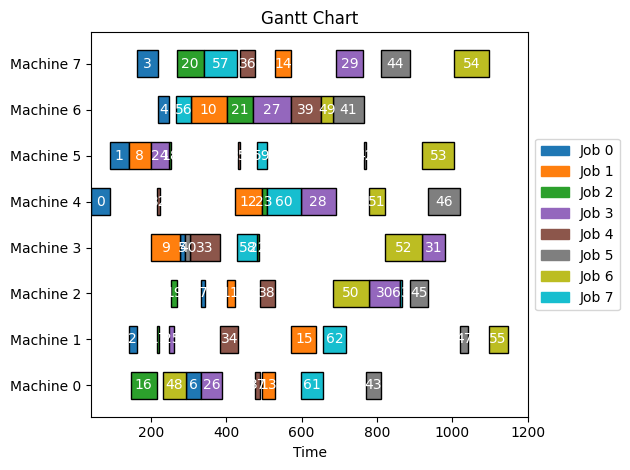

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
from matplotlib import pyplot as plt
from IPython.core.display_functions import clear_output

env.render(td, 0)
# Update plot within a for loop
while not td["done"].all():
    # Clear the previous output for the next iteration
    clear_output(wait=True)

    td = make_step(td=td ,decoder = policy.decoder)
    env.render(td, 0)
    # Display updated plot
    display(plt.gcf())

    # Pause for a moment to see the changes
    time.sleep(.4)

# Training model

In [10]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="djssp",
    het_emb=False
)

model = L2DPPOModel(
    env=env,
    policy=policy,
    batch_size=batch_size,
    train_data_size=train_data_size,
    val_data_size=1,
    optimizer_kwargs={"lr": 1e-4}
)

C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [11]:
td["time"]


tensor([1146.8174])

In [12]:
CHECKPOINT_PATH = "last.ckpt"
device = "cuda" if torch.cuda.is_available() else "cpu"


trainer = RL4COTrainer(
    max_epochs=1,
    accelerator=accelerator,
    devices=1,
    logger=None,
)

trainer.fit(model)

model = model.to(device)

C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Overriding gradient_clip_val t

Sanity Checking DataLoader 0:   0%|                                                              | 0/1 [00:00<?, ?it/s]

C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\soner\anaconda3\envs\env_rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   0%|                                                                                 | 0/250 [00:00<?, ?it/s]

RuntimeError: shape '[4, 1]' is invalid for input of size 16

In [ ]:

generator_params = {
"num_jobs" : 6 ,
"num_machines": 10 ,
"min_processing_time": 11 ,
"max_processing_time": 230 ,
"mtbf" : 8 ,
"mttr" : 3
}
new_env  = DJSSPEnv(generator_params=generator_params)
 

In [ ]:
new_td = new_env.reset(batch_size = [2])
out = model.policy.generate(new_td , env = new_env , phase ="test" ,decode_type="multistart_sampling", num_starts=100, select_best=True)
out

# Currently this part cannot be used since i dont have any FileGenerator 


In [ ]:
! git clone https://github.com/tamy0612/JSPLIB.git

In [ ]:
import json

def prepare_taillard_data(nj, nm):
    fp = f"taillard/{nj}x{nm}"
    if os.path.exists(fp):
        pass
    else:
        os.makedirs(fp)
        with open('../JSPLIB/instances.json', 'r') as file:
            data = json.load(file)

        instances = [x for x in data if "ta" in x["name"] and x["jobs"] == nj and x["machines"] == nm]

        for instance in instances:
            os.popen(f"cp JSPLIB/{instance['path']} {fp}/{instance['name']}.txt")


In [ ]:
# path to taillard instances
# FILE_PATH = "taillard/{nj}x{nm}"
import gc
from rl4co.envs import JSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os

FILE_PATH = "JSPLIB/taillard/{nj}x{nm}"
results = {}
instance_types = [(15, 15), (20, 15), (20, 20), (30, 15), (30, 20)]

for instance_type in instance_types:
    nj, nm = instance_type
    prepare_taillard_data(nj, nm)
    dataset = env.dataset(batch_size=[3], phase="test", filename=FILE_PATH.format(nj=nj, nm=nm))
    print(dataset)
    dl = DataLoader(dataset, batch_size=3, collate_fn=dataset.collate_fn)
    rewards = []

    for batch in dl:
        td = env.reset(batch).to(device)
        env.render(td,0)
        # use policy.generate to avoid grad calculations which can lead to oom
        out = model.policy.generate(td, env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)
        rewards.append(out["reward"])
        
        

    reward = torch.cat(rewards, dim=0).mean().item()
    results[instance_type] = reward

    print("Done evaluating instance type %s with reward %s" % (instance_type, reward))

    # avoid ooms due to cache not being cleared
    model.rb.empty()
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
import torch

torch.cuda.is_available()
